In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [4]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [5]:
y = train['scalar_coupling_constant']

In [8]:
train.head()

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000

In [9]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [6]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [7]:
params = {'num_leaves': 2**4,
          'min_child_samples': 80,
          'objective': 'regression',
          'max_depth': 5,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.1,
          'colsample_bytree': 1.0
         }

In [10]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_]
    test_ = test[test['type'] == type_]
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id']]
    features = ['atom_index_0', 'atom_index_1']

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
        trn_data = lgb.Dataset(x_train.iloc[train_idx], label=y_train.iloc[train_idx])
        val_data = lgb.Dataset(x_train.iloc[valid_idx], label=y_train.iloc[valid_idx])

        num_round = 10000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data],
                        verbose_eval=500, early_stopping_rounds = 200)
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 10.8343	valid_1's l1: 10.9311
[1000]	training's l1: 10.8321	valid_1's l1: 10.9299
Early stopping, best iteration is:
[852]	training's l1: 10.8317	valid_1's l1: 10.9295
Fold 2
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 10.857	valid_1's l1: 10.8623
[1000]	training's l1: 10.8534	valid_1's l1: 10.8586
Early stopping, best iteration is:
[1104]	training's l1: 10.853	valid_1's l1: 10.8583
Fold 3
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 10.8759	valid_1's l1: 10.8352
[1000]	training's l1: 10.872	valid_1's l1: 10.8314
Early stopping, best iteration is:
[1138]	training's l1: 10.8716	valid_1's l1: 10.831
Fold 4
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 10.8727	valid_1's l1: 10.8359
[1000]	training's l1: 10.8695	valid_1's l1: 10.8326
Early stopping, best iteration is:
[809]	training's 

Fold 4
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.45604	valid_1's l1: 2.45858
[1000]	training's l1: 2.45502	valid_1's l1: 2.45767
[1500]	training's l1: 2.45475	valid_1's l1: 2.45746
[2000]	training's l1: 2.45464	valid_1's l1: 2.4574
Early stopping, best iteration is:
[1918]	training's l1: 2.45462	valid_1's l1: 2.45737
Fold 5
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 2.45553	valid_1's l1: 2.45905
[1000]	training's l1: 2.45442	valid_1's l1: 2.4581
[1500]	training's l1: 2.45415	valid_1's l1: 2.45789
[2000]	training's l1: 2.454	valid_1's l1: 2.45777
Early stopping, best iteration is:
[2057]	training's l1: 2.45399	valid_1's l1: 2.45777
Fold 1
Training until validation scores don't improve for 200 rounds.
[500]	training's l1: 3.03102	valid_1's l1: 3.03002
[1000]	training's l1: 3.02924	valid_1's l1: 3.02819
[1500]	training's l1: 3.02873	valid_1's l1: 3.02768
[2000]	training's l1: 3.02848	valid_1's l1: 3.02748

In [11]:
predictions

array([-5.01457595e-02,  1.17441011e+02,  5.36111041e+00, ...,
        3.87969017e+00,  2.43636719e-02,  1.20336096e+02])

In [12]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [13]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [18]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.1.1.csv", index=False)

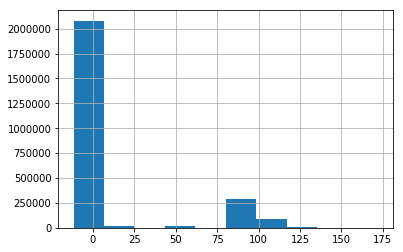

In [15]:
sub['scalar_coupling_constant'].hist()

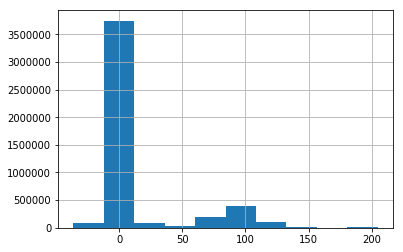

In [16]:
train['scalar_coupling_constant'].hist()

In [19]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.1.0.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.1.0.csv', index=False)